# <span style="color: green; font-size: 40px; font-weight: bold;"> Projeto: Classificação de Imagens de Veículos</span>

<br><br>

# Contexto

- Lucas trabalha em uma empresa de segurança que utiliza câmeras para monitorar o tráfego em diversas partes da cidade. Identificar manualmente os diferentes tipos de veículos nas imagens capturadas é uma tarefa demorada. Para resolver esse problema, Lucas decidiu usar a inteligência artificial para automatizar a identificação dos veículos. Ele encontrou um conjunto de dados no Kaggle contendo imagens de diferentes tipos de veículos e começou a desenvolver um modelo de classificação de imagens utilizando redes neurais convolucionais (CNNs).

<br><br>

## Importando Pacotes

In [1]:
# Importando pacotes necessários

import os  # Para manipulação de diretórios e arquivos
import numpy as np  # Para manipulação de arrays e operações numéricas
import pandas as pd  # Para análise de dados e estruturas de dados
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator  # Para processamento de imagens e augmentação de dados
import matplotlib.pyplot as plt  # Para visualização de dados
import seaborn as sns  # Para visualização de dados
from sklearn.model_selection import train_test_split  # Para divisão dos dados em conjuntos de treino e teste
from sklearn.preprocessing import LabelEncoder  # Para codificação de rótulos
from tensorflow.keras.utils import to_categorical  # Para conversão de rótulos em one-hot encoding
from tensorflow.keras.models import Sequential  # Para construção do modelo de rede neural
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Camadas da rede neural
from tensorflow.keras.models import load_model  # Para salvar e carregar modelos


2024-06-10 18:48:46.413688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-10 18:48:46.413701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<br><br>

## Download Conjunto de Dados

<br>

## Carregando Conjunto de Dados

- Carregando as imagens e rótulos do diretório do conjunto de dados.

In [2]:
def load_images(directory, target_size=(128, 128), max_images_per_class=1000):
    images = []
    labels = []
    label_count = {}

    for subset in ['train', 'test']:
        subset_dir = os.path.join(directory, subset)
        for label in os.listdir(subset_dir):
            if os.path.isdir(os.path.join(subset_dir, label)):
                label_count[label] = 0

    for subset in ['train', 'test']:
        subset_dir = os.path.join(directory, subset)
        for label in os.listdir(subset_dir):
            if os.path.isdir(os.path.join(subset_dir, label)):
                for file in os.listdir(os.path.join(subset_dir, label)):
                    if label_count[label] < max_images_per_class:
                        img_path = os.path.join(subset_dir, label, file)
                        img = load_img(img_path, target_size=target_size)
                        img_array = img_to_array(img)
                        images.append(img_array)
                        labels.append(label)
                        label_count[label] += 1
                    if len(images) >= max_images_per_class * len(label_count):
                        break
    return np.array(images), np.array(labels)

# Atualize o caminho do diretório após o download do dataset
data_dir = 'dados/cars/car_data'
images, labels = load_images(data_dir, max_images_per_class=10)

# Verificar as dimensões dos dados
print(f'Total de imagens: {images.shape[0]}')
print(f'Dimensão de cada imagem: {images.shape[1:]}')
print(f'Total de rótulos: {len(labels)}')

Total de imagens: 1960
Dimensão de cada imagem: (128, 128, 3)
Total de rótulos: 1960


<br>

## Análise dos Dados

- Realizando uma análise preliminar dos dados para verificar se estão corretos e prontos para o pré-processamento.

Total de imagens: 1960
Dimensão de cada imagem: (128, 128, 3)
Total de rótulos: 1960
Chevrolet Avalanche Crew Cab 2012    10
Dodge Charger Sedan 2012             10
Acura RL Sedan 2012                  10
Hyundai Elantra Sedan 2007           10
Bentley Continental GT Coupe 2007    10
                                     ..
Isuzu Ascender SUV 2008              10
Toyota Corolla Sedan 2012            10
Lamborghini Aventador Coupe 2012     10
Chevrolet Cobalt SS 2010             10
Chevrolet Impala Sedan 2007          10
Length: 196, dtype: int64


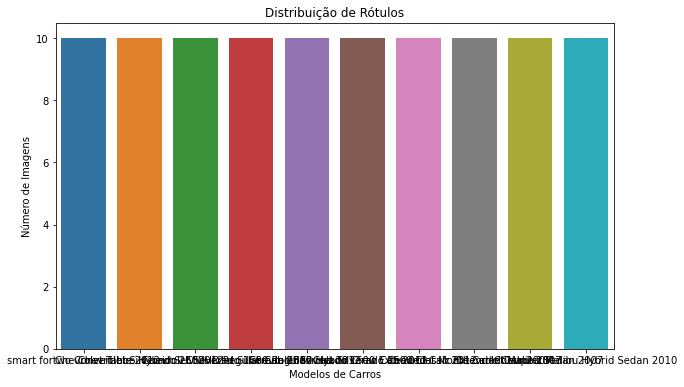

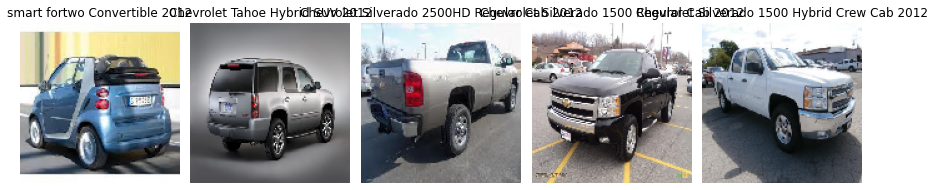

In [3]:
# Para este projeto, os rótulos são nomes de carros que não precisam de tradução
labels_translated = labels  # Mantemos os rótulos como estão

# Verificar as dimensões dos dados
print(f'Total de imagens: {images.shape[0]}')
print(f'Dimensão de cada imagem: {images.shape[1:]}')
print(f'Total de rótulos: {len(labels_translated)}')

# Verificar a distribuição dos rótulos
unique_labels, counts = np.unique(labels_translated, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]

# Mostrar value_counts() dos rótulos
labels_series = pd.Series(labels_translated)
print(labels_series.value_counts())

# Plotar a distribuição dos rótulos
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels[sorted_indices][:10], y=counts[sorted_indices][:10])  # Mostrar apenas as 10 classes mais comuns
plt.title('Distribuição de Rótulos')
plt.xlabel('Modelos de Carros')
plt.ylabel('Número de Imagens')
plt.show()

# Mostrar algumas imagens
plt.figure(figsize=(12, 8))
num_images_to_show = min(5, len(unique_labels))  # Ajuste para o número de classes
for i in range(num_images_to_show):
    label = unique_labels[sorted_indices[i]]
    label_indices = np.where(labels_translated == label)[0]
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(images[label_indices[0]].astype('uint8'))
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

<br>

## Pré-processamento de Dados
- **Carregando e rotulando as imagens**: Utilizamos **LabelEncoder** para transformar os rótulos de texto em rótulos numéricos.
- **Dividindo os dados em treino e teste**: Utilizamos **train_test_split** para dividir os dados em conjuntos de treino (80%) e teste (20%).
- **Normalizando os dados de entrada**: As imagens são normalizadas dividindo os valores dos pixels por 255.0, colocando-os na faixa de 0, 1.
- **Codificando os rótulos em one-hot**: Os rótulos numéricos são convertidos em uma representação one-hot, essencial para a camada de saída do modelo de classificação.
<br><br>
Este bloco de código garante que os dados estejam preparados adequadamente para o treinamento do modelo de aprendizado de máquina, melhorando a eficiência e a precisão do modelo.

In [4]:
# Dividindo os dados em treino e teste e normalizando as imagens
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_translated)

X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Verificar as dimensões dos dados de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Normalizar os dados de entrada
X_train = X_train / 255.0
X_test = X_test / 255.0

# Certifique-se de que ambos os conjuntos de treino e teste tenham o mesmo número de classes
num_classes = len(np.unique(labels_encoded))

# Codificar os rótulos em one-hot
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Verificar as dimensões dos dados de treino e teste
print(f'Forma de y_train: {y_train.shape}')
print(f'Forma de y_test: {y_test.shape}')

(1568, 128, 128, 3)
(392, 128, 128, 3)
(1568,)
(392,)
Forma de y_train: (1568, 196)
Forma de y_test: (392, 196)


<br>

## Criação, Compilação e Treinamento do Modelo

- Construímos o modelo de rede neural convolucional (CNN) utilizando Keras.
- Compilamos o modelo com o otimizador Adam e a função de perda categorical crossentropy.
- A técnica de **augmentação** de dados gera novas imagens a partir das imagens existentes, aumentando o tamanho efetivo do dataset sem a necessidade de coletar novas imagens reais. Isso ajuda a evitar overfitting, especialmente quando o dataset original é pequeno.
- Treinamos o modelo com os dados de treinamento e validamos com os dados de teste.

In [5]:
# Obter o número de classes
num_classes = len(np.unique(labels_encoded))  # Usar labels_encoded para garantir consistência

# Criação do Modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Certifique-se de que o número de classes esteja correto
])

# Compilação do Modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentação de Dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Treinando o Modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))
print(history)

2024-06-10 18:48:55.282506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-10 18:48:55.282523: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-10 18:48:55.282539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eduardo-Inspiron-15-3520): /proc/driver/nvidia/version does not exist
2024-06-10 18:48:55.282677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 18:48:55.456167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None o

Epoch 1/10
49/49 [==============================] - 14s 283ms/step - loss: 5.3224 - accuracy: 0.0038 - val_loss: 5.2811 - val_accuracy: 0.0000e+00
Epoch 2/10
49/49 [==============================] - 14s 281ms/step - loss: 5.2804 - accuracy: 0.0045 - val_loss: 5.2830 - val_accuracy: 0.0000e+00
Epoch 3/10
49/49 [==============================] - 14s 290ms/step - loss: 5.2655 - accuracy: 0.0064 - val_loss: 5.2479 - val_accuracy: 0.0000e+00
Epoch 4/10
49/49 [==============================] - 14s 288ms/step - loss: 5.2278 - accuracy: 0.0070 - val_loss: 5.2243 - val_accuracy: 0.0026
Epoch 5/10
49/49 [==============================] - 14s 282ms/step - loss: 5.1889 - accuracy: 0.0128 - val_loss: 5.2117 - val_accuracy: 0.0026
Epoch 6/10
49/49 [==============================] - 14s 284ms/step - loss: 5.1702 - accuracy: 0.0102 - val_loss: 5.2050 - val_accuracy: 0.0051
Epoch 7/10
49/49 [==============================] - 14s 281ms/step - loss: 5.1516 - accuracy: 0.0147 - val_loss: 5.2020 - val_accu

<br>

## Avaliação do Modelo

- Avaliamos o desempenho do modelo utilizando os dados de teste.

In [6]:
# Avaliação
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

13/13 [==============================] - 1s 56ms/step - loss: 5.3227 - accuracy: 0.0077
Test accuracy: 0.0076530613005161285


<br>

## Salvando e Carregando o Modelo

- Salvamos o modelo treinado em um arquivo e carregamos o modelo para uso futuro.

In [7]:
# Salvar o modelo
model.save('modelos_imagens/car_classifier_model.h5')

# Carregar o modelo
model = load_model('modelos_imagens/car_classifier_model.h5')

<br>

## Previsões com Novas Imagens

- Utilizamos o modelo para prever a classe de novas imagens. As novas imagens também precisam ser pré-processadas antes de serem passadas para o modelo.

In [8]:
def predict_image(image_path, model, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Exemplo de uso
image_path = 'novas_imagens/hrv.jpeg'
print(predict_image(image_path, model))

Ford E-Series Wagon Van 2012


<br><br>

### Resumo
- Este projeto orienta você através das etapas para criar um modelo de classificação de imagens de frutas usando deep learning. Começamos verificando e instalando pacotes necessários, fornecemos o link para o download do conjunto de dados, realizamos uma análise preliminar para garantir a qualidade dos dados, e passamos pelo pré-processamento, construção, treinamento, avaliação e salvamento do modelo. No final, mostramos como prever a classe de novas imagens, garantindo que elas sejam pré-processadas adequadamente antes de serem passadas para o modelo.